In [1]:
import requests
from PIL import Image
import torch

import numpy as np
import cv2
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

######################

from transformers import Owlv2Processor, Owlv2ForObjectDetection
processor_owl = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model_owl = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble").to(device)

#######################

from transformers import BlipProcessor, BlipForConditionalGeneration

model_id = "Salesforce/blip-image-captioning-base"
processor_blip = BlipProcessor.from_pretrained(model_id)
model_blip = BlipForConditionalGeneration.from_pretrained(model_id).to(device)

######################

import spacy

# Load the pre-trained spaCy model
nlp = spacy.load("en_core_web_md")

def extract_nouns_spacy(sentence):
    # Process the sentence
    doc = nlp(sentence)
    
    # Extract nouns
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    
    return nouns

0


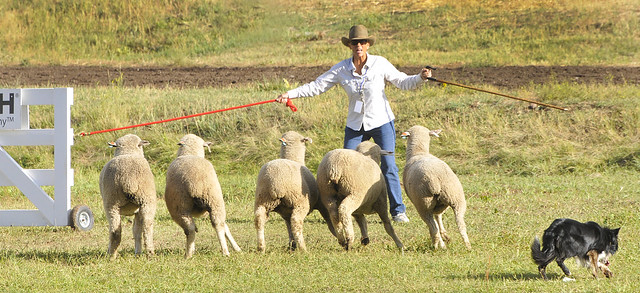

In [2]:
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
url = 'http://farm9.staticflickr.com/8437/7910770924_e51c726cc7_z.jpg'
# url = "http://farm5.staticflickr.com/4055/4590650151_c410906e50_z.jpg"
# url = "http://farm8.staticflickr.com/7154/6506781427_965a5f2bc6_z.jpg"
# url = "http://farm3.staticflickr.com/2220/2218961434_7916358f53_z.jpg"
# url = "http://farm4.staticflickr.com/3468/3985002426_7ac078228e_z.jpg"
image_ori = Image.open(requests.get(url, stream=True).raw)
image = image_ori.resize((1024, 1024))
# image = image_ori

index = 0
print(index)

image_ori

In [4]:
# Prepare the image for the model
inputs = processor_blip(images=image, return_tensors="pt", text="").to(device)

# Generate captions
outputs = model_blip.generate(**inputs, max_length=512, num_beams=3, return_dict_in_generate=True)

# Decode and print the caption
caption = processor_blip.decode(outputs.sequences[0], skip_special_tokens=True)
print(caption)

a woman walking a herd of sheep on a leash


In [5]:
nouns = extract_nouns_spacy(caption)
print(nouns)

extented_nouns = []
for noun in nouns:
    extented_nouns.append("a image of " + noun)

print(extented_nouns)


['woman', 'herd', 'sheep', 'leash']
['a image of woman', 'a image of herd', 'a image of sheep', 'a image of leash']


In [6]:
image_pt = torch.tensor(np.array(image)).permute(2, 0, 1)


inputs = processor_owl(text=[nouns], images=image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model_owl(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
results = processor_owl.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.25)
i = 0  # Retrieve predictions for the first image for the corresponding text queries

boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {nouns[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected leash with confidence 0.544 at location [122.59, 340.81, 468.83, 475.41]
Detected woman with confidence 0.283 at location [441.01, 89.36, 696.35, 776.02]
Detected sheep with confidence 0.33 at location [567.81, 486.7, 615.68, 586.22]
Detected sheep with confidence 0.634 at location [406.13, 459.45, 519.64, 880.43]
Detected sheep with confidence 0.639 at location [639.34, 440.54, 756.83, 875.98]
Detected sheep with confidence 0.676 at location [505.48, 480.11, 651.35, 878.26]
Detected sheep with confidence 0.654 at location [261.24, 469.14, 390.88, 904.0]
Detected sheep with confidence 0.635 at location [158.17, 469.54, 255.64, 906.01]
Detected herd with confidence 0.412 at location [161.73, 441.08, 739.74, 902.87]
Detected sheep with confidence 0.286 at location [847.59, 761.06, 993.27, 983.14]


In [7]:
outputs.image_embeds.shape

torch.Size([1, 60, 60, 768])

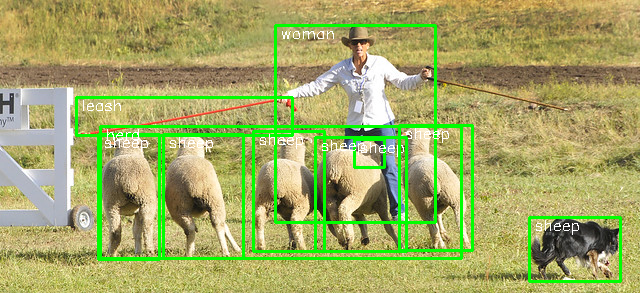

In [9]:
image_result = np.array(image_ori)
height, width, _ = image_result.shape

for box, score, label in zip(boxes, scores, labels):
    box = [int(i) for i in box.tolist()]
    x1 = int(box[0] * width / 1024)
    y1 = int(box[1] * height / 1024)
    x2 = int(box[2] * width / 1024)
    y2 = int(box[3] * height / 1024)

    cv2.rectangle(
        image_result, (x1, y1), (x2, y2), (0, 255, 0), 2
    )
    cv2.putText(
        image_result,
        f"{nouns[label]}",
        (x1+5, y1 +13),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        1,
    )

cv2.imwrite(f"images/{index}_baseline.jpg", cv2.cvtColor(image_result, cv2.COLOR_RGB2BGR))
Image.fromarray(image_result)

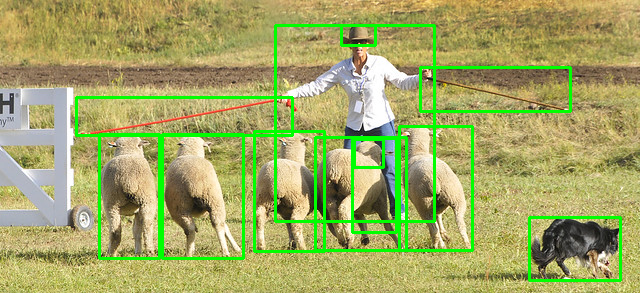

In [10]:
obejectness = torch.sigmoid(outputs.objectness_logits) > 0.2
indices = torch.where(obejectness)[1]

bboxes = outputs.pred_boxes[0][indices]

image_result = np.array(image_ori)
height, width, _ = image_result.shape

for box in bboxes:
    # box = [int(i * 512) for i in box.tolist()]
    cx, cy = int(box[0] * width), int(box[1] * height)
    w, h = int(box[2] * width), int(box[3] * height)
    x1, y1 = int(cx - w / 2), int(cy - h / 2)
    x2, y2 = int(cx + w / 2), int(cy + h / 2)
    cv2.rectangle(
        image_result, (x1, y1), (x2, y2), (0, 255, 0), 2
    )

cv2.imwrite(f"images/{index}_objects.jpg", cv2.cvtColor(image_result, cv2.COLOR_RGB2BGR))
Image.fromarray(image_result)